## LOL WINNER


게임 시작 10분 시점에 대한 데이터를 분석하여 승패를 예측하는 DL모델 (이진분류)

데이터셋 - 리그 오브 레전드 다이아몬드 티어 랭크 (캐글) https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min

In [31]:
# 필요한 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler # RobustScaler 추가
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, 
    confusion_matrix, ConfusionMatrixDisplay, f1_score
)
from imblearn.over_sampling import SMOTE # SMOTE (클래스 불균형 해소)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import optuna
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 불러오기



In [32]:
df = pd.read_csv("./data/high_diamond_ranked_10min.csv")
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [34]:
df.describe()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9.879000e+03,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,2.757328e+07,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,4.483301e+09,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,4.521733e+09,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


In [35]:
df.shape

(9879, 40)

In [36]:
df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

In [37]:
df['blueWins'].value_counts()

blueWins
0    4949
1    4930
Name: count, dtype: int64

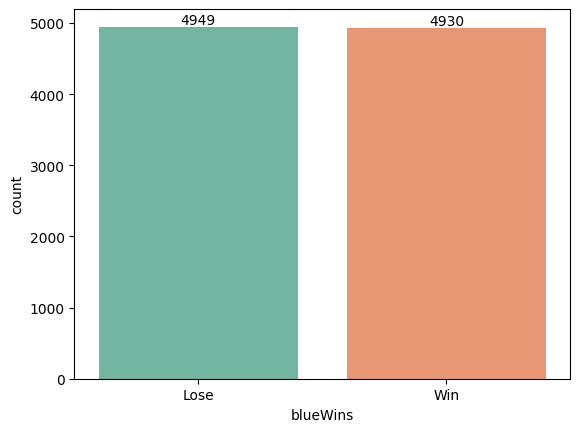

In [38]:
# 타겟변수 비율 확인 시각화
ji = sns.countplot(data=df, x='blueWins',palette="Set2")

for container in ji.containers:
    ji.bar_label(container)
plt.xticks([0,1],labels=["Lose","Win"])
plt.show()

In [39]:
cols = ['gameId', 'redGoldDiff', 'redExperienceDiff', 'redKills', 'redDeaths']
df = df.drop(columns=cols) 
X = df.drop(columns=['blueWins'])
y = df['blueWins'] 

In [40]:
#학습/검증/테스트 데이터 분리
# Test 데이터 분리 (20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train/Validation 분리 (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (5927, 34), Val: (1976, 34), Test: (1976, 34)


In [41]:
# 데이터 스케일링 
scaler = RobustScaler() 
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [42]:
# Tensor 데이터 변환
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [43]:
# 미니 배치 (DataLoader)
def make_loader(batch_size=64):
    train_loader = DataLoader(
        TensorDataset(X_train_t, y_train_t),
        batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(X_val_t, y_val_t),
        batch_size=batch_size, shuffle=False
    )
    test_loader = DataLoader(
        TensorDataset(X_test_t, y_test_t),
        batch_size=batch_size, shuffle=False
    )
    return train_loader, val_loader, test_loader

In [44]:
# 모델 준비-DNN 
class LoL_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32,dropout_p=0.3):
        super().__init__()
        
        # 성능 향상을 위한 구조: Linear -> BatchNorm -> LeakyReLU -> Dropout
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_p)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_p)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.BatchNorm1d(hidden_dim3),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_p)
        )
        self.fc_out = nn.Linear(hidden_dim3, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc_out(x)
        return x

In [45]:
# 학습 및 평가 함수
criterion = nn.BCEWithLogitsLoss() # 손실함수

def train_one_epoch(model, loader, optimizer):
    model.train()
    losses = []
    for xb, yb in loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    losses = []
    y_true_all = []
    y_prob_all = []
    
    for xb, yb in loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        prob = torch.sigmoid(logits)
        
        losses.append(loss.item())
        y_true_all.append(yb.cpu().numpy())
        y_prob_all.append(prob.cpu().numpy())
         
    y_true = np.vstack(y_true_all).ravel()
    y_prob = np.vstack(y_prob_all).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred) 
    
    return float(np.mean(losses)), acc, auc, f1, y_true, y_prob

In [46]:
# Early Stopping 
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

In [47]:
# 학습 통합 함수- AdamW 
def fit(model, train_loader, val_loader, lr=1e-3, n_epochs=200, weight_decay=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay) 
    
    hist = {"train_loss": [], "val_loss": [], "val_acc": [], "val_auc": []}
    best_val = np.inf
    best_state = None
    early = EarlyStopping(patience=15)
    
    for epoch in range(1, n_epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer)
        va_loss, va_acc, va_auc, va_f1, _, _ = evaluate(model, val_loader)
        
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["val_acc"].append(va_acc)
        hist["val_auc"].append(va_auc)
        
        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            
        early.step(va_loss)
        if early.stop:
            print(f" Early Stopping at epoch {epoch}")
            break
            
    if best_state is not None:
        model.load_state_dict(best_state)
    return hist

In [48]:
# Optuna 하이퍼파라미터 튜닝
def objective(trial):
    # 탐색 공간 정의
    hidden_dim1 = trial.suggest_categorical("hidden_dim1", [64, 128, 256])
    hidden_dim2 = trial.suggest_categorical("hidden_dim2", [32, 64, 128])
    hidden_dim3 = trial.suggest_categorical("hidden_dim3", [16, 32, 64])
    dropout_p = trial.suggest_float("dropout_p", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
    # DataLoader 생성
    train_loader, val_loader, _ = make_loader(batch_size=batch_size)
    
    # 모델 생성
    model = LoL_MLP(
        input_dim=X_train.shape[1],
        hidden_dim1=hidden_dim1,
        hidden_dim2=hidden_dim2,
        hidden_dim3=hidden_dim3,
        dropout_p=dropout_p
    )
    
    # 학습
    hist = fit(model, train_loader, val_loader, lr=lr, n_epochs=50, weight_decay=weight_decay)
    
    # 평가지표 반환 
    return max(hist['val_auc'])

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2026-01-08 08:52:44,848] A new study created in memory with name: no-name-b3a52b34-c383-4a7e-a12e-2c4fc94b8913
[I 2026-01-08 08:52:47,069] Trial 0 finished with value: 0.8019781998483826 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 64, 'hidden_dim3': 32, 'dropout_p': 0.35514842414880443, 'lr': 0.009216811419123424, 'weight_decay': 1.0121742710502852e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8019781998483826.


 Early Stopping at epoch 18


[I 2026-01-08 08:52:57,555] Trial 1 finished with value: 0.8001915708812259 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 64, 'hidden_dim3': 64, 'dropout_p': 0.31037921168996385, 'lr': 0.00011136764950253814, 'weight_decay': 0.00015796875569619014, 'batch_size': 32}. Best is trial 0 with value: 0.8019781998483826.
[I 2026-01-08 08:52:58,917] Trial 2 finished with value: 0.8007539902063228 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 128, 'hidden_dim3': 32, 'dropout_p': 0.3269864972680392, 'lr': 0.002017131337038743, 'weight_decay': 0.00038565007599149036, 'batch_size': 128}. Best is trial 0 with value: 0.8019781998483826.


 Early Stopping at epoch 18


[I 2026-01-08 08:53:01,388] Trial 3 finished with value: 0.8020437642141496 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 64, 'hidden_dim3': 16, 'dropout_p': 0.34795011813591914, 'lr': 0.000653293429219002, 'weight_decay': 7.716236157427452e-06, 'batch_size': 64}. Best is trial 3 with value: 0.8020437642141496.


 Early Stopping at epoch 22


[I 2026-01-08 08:53:03,278] Trial 4 finished with value: 0.8019105865961851 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'hidden_dim3': 16, 'dropout_p': 0.3304164658765106, 'lr': 0.009142401420813837, 'weight_decay': 0.0004805900132451072, 'batch_size': 64}. Best is trial 3 with value: 0.8020437642141496.


 Early Stopping at epoch 17


[I 2026-01-08 08:53:05,518] Trial 5 finished with value: 0.801347142827873 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 64, 'hidden_dim3': 16, 'dropout_p': 0.2216921026151734, 'lr': 0.006231864847932454, 'weight_decay': 2.5063066559803e-06, 'batch_size': 64}. Best is trial 3 with value: 0.8020437642141496.


 Early Stopping at epoch 20


[I 2026-01-08 08:53:06,925] Trial 6 finished with value: 0.8015499825844653 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'hidden_dim3': 16, 'dropout_p': 0.20771625550787093, 'lr': 0.005047087000487439, 'weight_decay': 3.424633453742287e-06, 'batch_size': 128}. Best is trial 3 with value: 0.8020437642141496.


 Early Stopping at epoch 18


[I 2026-01-08 08:53:10,009] Trial 7 finished with value: 0.8007591124223984 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 128, 'hidden_dim3': 32, 'dropout_p': 0.201312274618278, 'lr': 0.00011155858613006548, 'weight_decay': 0.00039217991443495466, 'batch_size': 64}. Best is trial 3 with value: 0.8020437642141496.


 Early Stopping at epoch 24


[I 2026-01-08 08:53:12,275] Trial 8 finished with value: 0.8020785952834634 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 64, 'hidden_dim3': 32, 'dropout_p': 0.3363319309821549, 'lr': 0.0018122177905994454, 'weight_decay': 1.5071198948238326e-06, 'batch_size': 64}. Best is trial 8 with value: 0.8020785952834634.


 Early Stopping at epoch 19


[I 2026-01-08 08:53:14,946] Trial 9 finished with value: 0.8025139836498864 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.3918861727753146, 'lr': 0.0003557948293725427, 'weight_decay': 0.0003687152459670735, 'batch_size': 64}. Best is trial 9 with value: 0.8025139836498864.


 Early Stopping at epoch 23


[I 2026-01-08 08:53:23,369] Trial 10 finished with value: 0.802356219394759 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.491446932388239, 'lr': 0.00034789872667093205, 'weight_decay': 5.778923031644935e-05, 'batch_size': 32}. Best is trial 9 with value: 0.8025139836498864.


 Early Stopping at epoch 44


[I 2026-01-08 08:53:28,713] Trial 11 finished with value: 0.8019884442805336 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.490638981539224, 'lr': 0.0003590406757039819, 'weight_decay': 6.620765066991419e-05, 'batch_size': 32}. Best is trial 9 with value: 0.8025139836498864.


 Early Stopping at epoch 28


[I 2026-01-08 08:53:34,807] Trial 12 finished with value: 0.8014782715594075 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.49644153304255023, 'lr': 0.0003262845834091346, 'weight_decay': 4.007896196000477e-05, 'batch_size': 32}. Best is trial 9 with value: 0.8025139836498864.


 Early Stopping at epoch 32


[I 2026-01-08 08:53:44,283] Trial 13 finished with value: 0.8023890015776426 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.4416984323546412, 'lr': 0.00027452696197861854, 'weight_decay': 0.0001124761591841711, 'batch_size': 32}. Best is trial 9 with value: 0.8025139836498864.
[I 2026-01-08 08:53:53,837] Trial 14 finished with value: 0.8013246050771405 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.4208480753942194, 'lr': 0.0002178332811949741, 'weight_decay': 0.00012101674423288857, 'batch_size': 32}. Best is trial 9 with value: 0.8025139836498864.


 Early Stopping at epoch 47


[I 2026-01-08 08:53:55,547] Trial 15 finished with value: 0.801483393775483 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.4190555571289363, 'lr': 0.0012418841579537904, 'weight_decay': 0.0009106971389159854, 'batch_size': 128}. Best is trial 9 with value: 0.8025139836498864.


 Early Stopping at epoch 26


[I 2026-01-08 08:54:00,864] Trial 16 finished with value: 0.8032331427868953 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.4202799899827997, 'lr': 0.0006379710795504527, 'weight_decay': 0.00016483099163870676, 'batch_size': 32}. Best is trial 16 with value: 0.8032331427868953.


 Early Stopping at epoch 26


[I 2026-01-08 08:54:05,609] Trial 17 finished with value: 0.8013246050771405 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 128, 'hidden_dim3': 64, 'dropout_p': 0.38070959748369765, 'lr': 0.0006432580439001244, 'weight_decay': 2.023022926783456e-05, 'batch_size': 32}. Best is trial 16 with value: 0.8032331427868953.


 Early Stopping at epoch 20


[I 2026-01-08 08:54:08,177] Trial 18 finished with value: 0.8011719630380887 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.2630805211595153, 'lr': 0.0006802438967398256, 'weight_decay': 0.0002206686666569743, 'batch_size': 64}. Best is trial 16 with value: 0.8032331427868953.


 Early Stopping at epoch 22


[I 2026-01-08 08:54:09,576] Trial 19 finished with value: 0.8011627430491528 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'hidden_dim3': 64, 'dropout_p': 0.3808411466297817, 'lr': 0.0030572463606766583, 'weight_decay': 0.0008146960522778982, 'batch_size': 128}. Best is trial 16 with value: 0.8032331427868953.


 Early Stopping at epoch 18


In [49]:
# 최적 파라미터 적용
best = study.best_params
train_loader, val_loader, test_loader = make_loader(batch_size=best['batch_size'])
best_model = LoL_MLP(
    input_dim=X_train.shape[1],
    hidden_dim1=best['hidden_dim1'],
    hidden_dim2=best['hidden_dim2'],
    dropout_p=best['dropout_p']
)

# 재학습 
history = fit(
    best_model, train_loader, val_loader,
    lr=best['lr'], n_epochs=200, weight_decay=best['weight_decay']
)

 Early Stopping at epoch 17


In [50]:
# 최종 테스트 평가
test_loss, test_acc, test_auc, test_f1, y_true, y_prob = evaluate(best_model, test_loader)
print(f"최종 Test 결과 Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}, F1: {test_f1:.4f}")

최종 Test 결과 Loss: 0.5316, Acc: 0.7196, AUC: 0.8070, F1: 0.7230


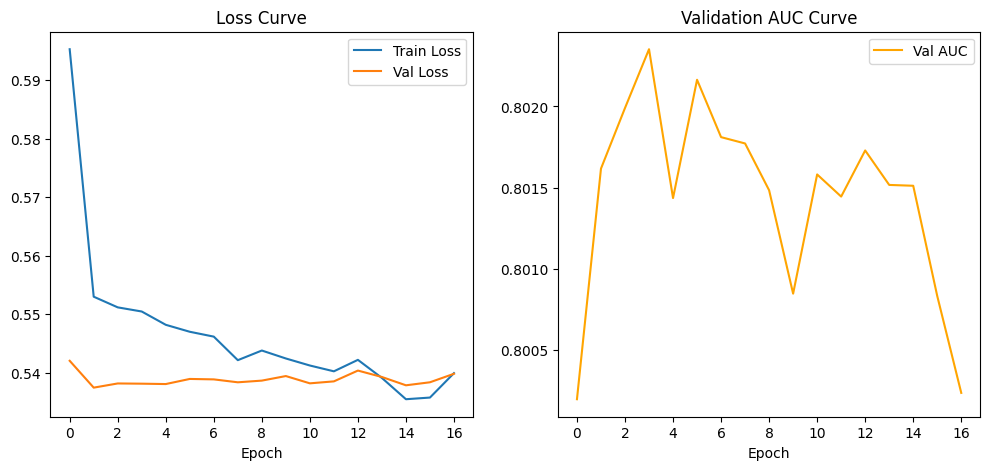

In [51]:
# 학습 곡선
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_auc'], label='Val AUC', color='orange')
plt.title('Validation AUC Curve')
plt.xlabel('Epoch')
plt.legend()
plt.show()



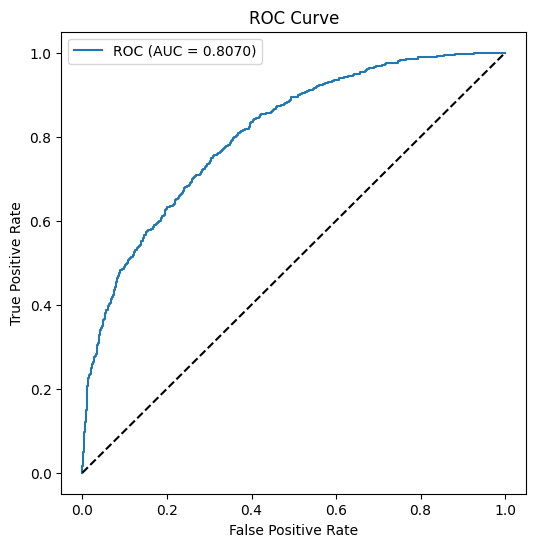

In [52]:
# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

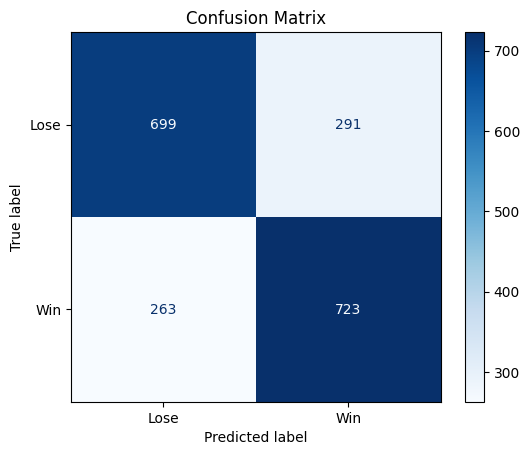

In [53]:
# 3. Confusion Matrix
y_pred = (y_prob > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Lose', 'Win'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()